# Overview
- validation の切り方を工夫する

In [1]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

f5c196b


# Const

In [2]:
# basic
DEBUG = False 
NB = '019'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
PATH_DRUGID = '../data_ignore/input/train_drug.csv'
SAVE_DIR = f'../data_ignore/output_nb/nb{NB}/'
PATH_GROUP696 = './../data_ignore/output_nb/nb004/group.csv'

In [3]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: MultiStratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: SmoothLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [4]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from glob import glob
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import Dataset, DataLoader

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [5]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [6]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, _X_valid, y_valid):
        X_valid = pd.DataFrame(_X_valid, columns=FEAT_COLUMNS)
        self.n_feat = len(X_valid.columns)
        
        val_set = MoaDataset(_X_valid, y_valid, mode='train')
        dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
        y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
        
        
        self.base_score = self.metric(y_valid, y_valid_pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(progress_bar(X_valid.columns)):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            
#             y_valid_pred = self.model.predict(df_perm)
            val_set = MoaDataset(df_perm.values, y_valid, mode='train')
            dataloaders = {'val': DataLoader(val_set, **settings['loader']['val'])}
            y_valid_pred = get_epoch_pred(self.model, device, dataloaders['val'])
            
            score = self.metric(y_valid, y_valid_pred)
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

In [7]:
class MoaModel(nn.Module):
    def __init__(self, n_input, n_output):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(n_input)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_input, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
#         self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, n_output))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x_raw = self.dense3(x)
        x_sigmoid = F.sigmoid(x_raw)
        
        return x_sigmoid, x_raw

In [8]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [9]:
def mean_log_loss(y_true, y_pred):
    metrics = []
#     for i in range(y_true.shape[1]):
#         metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
#     return np.mean(metrics)
    y_true =  y_true.astype(np.float64).ravel()
    y_pred =  y_pred.astype(np.float64).ravel()
    return log_loss(y_true, y_pred, labels=[0, 1])

class SmoothBCEwLogits(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.001):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets:torch.Tensor, n_labels:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = targets * (1.0 - smoothing) + 0.5 * smoothing
        return targets

    def forward(self, inputs, targets):
        targets = SmoothBCEwLogits._smooth(targets, inputs.size(-1),
            self.smoothing)
        loss = F.binary_cross_entropy_with_logits(inputs, targets,self.weight)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [10]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         if not DEBUG:
        torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss

In [11]:
def train_model(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() / len(train_loader)
    scheduler.step()
    return running_loss

def get_epoch_loss_score(model, device, valid_loader, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
            loss = criterion(pred_raw, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

def get_epoch_pred(model, device, valid_loader):
    model.eval()
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(False):
            pred_sigmoid, pred_raw = model(x)
        targets.append(y)
        preds.append(pred_sigmoid)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    return preds

In [12]:
def run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=True):
    device = torch.device("cuda")
    model = ModelClass(shape[0], shape[1]).to(device)
#     model = ModelClass(train.shape[1], ).to(device)
    early_stopping = EarlyStopping(patience=15, verbose=show_log, path=checkpoint_path)
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    
    best_valid_loss = np.inf
    best_mean_log_loss = np.inf
    best_preds = 0
    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        train_loss =  train_model(model, device, dataloaders['train'], optimizer, scheduler, criterion)
        valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, dataloaders['val'], criterion, optimizer)

        trn_losses.append(train_loss)
        val_losses.append(valid_loss)
        if show_log:
            print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {train_loss:5.5f}   val_loss: {valid_loss:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_mean_log_loss = _mean_log_loss
            best_preds = preds
    return best_mean_log_loss, best_preds, trn_losses, val_losses

def run(splitter, train, targets, ModelClass, show_log=True, pi=False):
    mean_log_loss_list = []
    oof = np.zeros_like(targets).astype(float)
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
        print('-'*100)
        print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
        print('-'*100)
        X_trn, X_val = train[idx_trn], train[idx_val]
        y_trn, y_val = targets[idx_trn], targets[idx_val]

        train_set = MoaDataset(X_trn, y_trn, mode='train')
        val_set = MoaDataset(X_val, y_val, mode='train')

        dataloaders = {
            'train': DataLoader(train_set, **settings['loader']['train']),
            'val': DataLoader(val_set, **settings['loader']['val']),
        }

        checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
        shape = (X_trn.shape[1], y_trn.shape[1])
        best_mean_log_loss, best_preds, trn_losses, val_losses =  run_fold(dataloaders, shape, checkpoint_path, ModelClass, show_log=show_log)

        # result
        print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
        mean_log_loss_list.append(best_mean_log_loss)
        oof[idx_val, :] = best_preds
        
        # permutation importance
        if pi:
            device = torch.device("cuda")
            model = ModelClass(shape[0], shape[1]).to(device)
            state_dict = torch.load(checkpoint_path)
            model.load_state_dict(state_dict)
            model.to(device)
            model.eval()
            pi = permutation_importance(model, mean_log_loss) # model と metric を渡す
            pi.compute(X_val, y_val)
            pi_result = pi.df_result
            df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
    #         pi.show_permutation_importance(score_type='loss')
        
        # plot
        if show_log:
            x = np.arange(1, len(trn_losses)+1)
            plt.figure(figsize=(12, 7))
            plt.plot(x[1:], trn_losses[1:], '--.', label='train')
            plt.plot(x[1:], val_losses[1:], '--.', label='valid')
            plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
            plt.legend()
            plt.show()
        print('\n')
    
    if pi:
        # permutation score
        plt.figure(figsize=(15, int(0.25*len(FEAT_COLUMNS))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=True)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()
    return mean_log_loss_list, oof, df_pi

# Preparation

set

In [13]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
# sns.set_context('talk')
sns.set_context('notebook')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [14]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [15]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
train_drug = pd.read_csv(PATH_DRUGID)
group696 = pd.read_csv(PATH_GROUP696)
# test_features = pd.read_csv(PATH_TEST)

# ss = pd.read_csv(PATH_SUB)

In [16]:
# step_row = 100
end_col = 10
step_row = 10
# step_row = 4
# step_row = 2
if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::step_row, :end_col]
    train_targets = train_targets.iloc[::step_row, :]
#     test_features = test_features.iloc[::100, :]

<br>

preprocess

In [17]:
mask_trt = (train_features['cp_type'] == 'trt_cp').values
train = preprocess(train_features)
FEAT_COLUMNS = train_features.columns[2:]
# test = preprocess(test_features).values

del train_targets['sig_id']

target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [18]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


<br>

load oof

In [19]:
path = '../data_ignore/output_nb/nb013/oof.csv'
df_oof = pd.read_csv(path)
oof = df_oof.values[:, :-1]
df_oof.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,fold
0,0.003428,0.001405,0.000703,0.005459,0.068069,0.007565,0.006974,0.002605,0.000736,0.023679,...,0.000611,0.002231,0.000627,0.002979,0.000706,0.000589,0.001297,0.000444,0.002598,3
1,0.000824,0.000599,0.001830,0.017313,0.013250,0.004077,0.002426,0.002496,0.001395,0.013766,...,0.002163,0.003794,0.002362,0.002224,0.000809,0.001549,0.002565,0.008342,0.006311,5
2,0.004459,0.005623,0.001095,0.005052,0.016952,0.006443,0.001563,0.010359,0.000897,0.003232,...,0.002149,0.001665,0.005329,0.003227,0.001696,0.014682,0.002368,0.000777,0.002813,2
3,0.000276,0.000743,0.001317,0.004430,0.002437,0.000435,0.001486,0.000419,0.000445,0.001194,...,0.017621,0.001743,0.135419,0.003500,0.001019,0.001207,0.001212,0.000353,0.000621,1
4,0.000646,0.001003,0.007079,0.012863,0.012686,0.002953,0.010215,0.003091,0.001398,0.008687,...,0.003503,0.002866,0.001668,0.002689,0.000652,0.001471,0.005410,0.000728,0.001826,4


# Analysis
以下の条件がそろったバリデーションを構築したい
- 薬剤リークがない
- MoAの組み合わせを均等に分けたい(696グループ)
- 各foldのデータ数を一定にしたい
- 5fold

- how to
    1. 696グループに分割
    1. あるグループiを選択
    1. グループi内MoAの組み合わせは同じだが、異なる薬剤が入っているのでそれらに1~5の番号を薬剤に割り振る
    1. i+1のグループ内の薬剤にも1~5に割り振るが1~5のfoldに割り当てられてるsig_idの総数の少ないものにsig_id数の多い薬剤を割り当てる(←数を調整する)
    1. i+2も同様

In [20]:
group696

,sig_id,group
0,id_000644bb2,1
1,id_000779bfc,0
2,id_000a6266a,2
3,id_0015fd391,0
4,id_001626bd3,3
...,...,...
23809,id_fffb1ceed,26
23810,id_fffb70c0c,237
23811,id_fffc1c3f4,0
23812,id_fffcb9e7c,5


In [21]:
groups = group696[mask_trt].group.values
groups

array([  1,   0,   2, ..., 237,   5,   0])

<br>

あるグループを選択(例として40)して、そのグループ内の薬剤に割り当てられたsig_id数を確認

In [22]:
mask_grp = groups == 40
# mask_grp = groups == 0
drug_rank = train_drug[mask_trt][mask_grp].drug_id.value_counts()
drug_rank

1a52478dc    14
5c68cde71    12
82da03539    12
af22cc3d8     7
313383238     6
4521062d2     6
fdf3069d4     6
aa29a93b4     6
50f201d36     6
eb56effe8     6
ca8387b14     6
eca05dee9     6
5f146f9eb     6
f2d2549de     6
9289a3800     6
7e6d15fce     6
13f0fc7ff     6
071afe3da     6
900711768     6
07502fc59     6
cf21bab1b     6
8bef1a5b2     6
755b7d1c4     6
bef164506     6
cebb37606     6
d7d9a5092     6
814afd3ab     5
a90e40334     1
e6b7b845f     1
Name: drug_id, dtype: int64

<br>

foldを割り当てていく

In [23]:
tile = [1, 2, 3, 4, 5]

In [24]:
n_repeat = np.ceil(len(drug_rank)/5).astype(int)

In [25]:
folds = np.tile(tile, n_repeat)[:len(drug_rank)]
folds

array([1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2,
       3, 4, 5, 1, 2, 3, 4])

In [26]:
df_rank = pd.DataFrame()
df_rank['drug_id'] = drug_rank.index
df_rank['n_sig_id'] = drug_rank.values
df_rank['fold'] = folds
df_rank

,drug_id,n_sig_id,fold
0,1a52478dc,14,1
1,5c68cde71,12,2
2,82da03539,12,3
3,af22cc3d8,7,4
4,313383238,6,5
5,4521062d2,6,1
6,fdf3069d4,6,2
7,aa29a93b4,6,3
8,50f201d36,6,4
9,eb56effe8,6,5


In [27]:
train_drug_trt = train_drug[mask_trt]
train_drug_trt['fold'] = 0
train_drug_trt.fold.value_counts()

0    21948
Name: fold, dtype: int64

In [28]:
for i, drug_id in enumerate(df_rank.drug_id.values):
    mask = train_drug_trt.drug_id.values == drug_id
    train_drug_trt.fold[mask] = df_rank.fold.values[i]
train_drug_trt.fold.value_counts()

0    21764
1       44
2       41
3       37
4       32
5       30
Name: fold, dtype: int64

---> 割り振っていないやつはfold=0になっている。  
---> 次のグループに割り当てるときは、一番少ないfold=5から順番に振っていく

<br>

次はgroup=41に割り振る。  
fold = 5から順番に割り振る。

In [29]:
tile = train_drug_trt.fold.value_counts()[::-1][:5].index
tile

Int64Index([5, 4, 3, 2, 1], dtype='int64')

In [30]:
mask_grp = groups == 41
drug_rank = train_drug_trt[mask_grp].drug_id.value_counts()
drug_rank

66f251fd0    6
7c1e00d49    1
Name: drug_id, dtype: int64

<br>

foldを割り当てていく

In [31]:
n_repeat = np.ceil(len(drug_rank)/5).astype(int)
folds = np.tile(tile, n_repeat)[:len(drug_rank)]
folds

array([5, 4])

In [32]:
df_rank = pd.DataFrame()
df_rank['drug_id'] = drug_rank.index
df_rank['n_sig_id'] = drug_rank.values
df_rank['fold'] = folds
df_rank

,drug_id,n_sig_id,fold
0,66f251fd0,6,5
1,7c1e00d49,1,4


In [33]:
for i, drug_id in enumerate(df_rank.drug_id.values):
    mask = train_drug_trt.drug_id.values == drug_id
    train_drug_trt.fold[mask] = df_rank.fold.values[i]
train_drug_trt.fold.value_counts()

0    21757
1       44
2       41
3       37
5       36
4       33
Name: fold, dtype: int64

次に割り振る時の順番は、fold= 4, 5, 3, 2, 1 の順番となる

# Summary
- まとめる。
- 注意点
    - 以下の条件を満たすものにはfold0を割り振る
        - ctrl
        - top8(nb018)

In [34]:
n_splits = 5
top8_drug = ['87d714366', '9f80f3f77', '8b87a7a83', '5628cb3ee', 'd08af5d4b', '292ab2c28', 'd50f18348', 'd1b47f29d']

In [35]:
mask_top8 = []
for drug_id in train_drug.drug_id.values:
    if drug_id in top8_drug:
        mask_top8.append(True)
    else:
        mask_top8.append(False)
mask_top8 = np.array(mask_top8)

In [36]:
# group = 0 は要素数が多いので一番最後にやるようにする
drug_groups = group696[mask_trt & ~mask_top8].group.values
groups = np.sort(group696[mask_trt & ~mask_top8].group.unique())
groups = groups[1:]
groups = np.append(groups, 0)

In [37]:
tile = []
train_drug_trt = train_drug[mask_trt & ~mask_top8]
train_drug_trt['fold'] = -1
for i_grp, grp in enumerate(progress_bar(groups)):
    if i_grp == 0:
        tile = np.arange(1, n_splits+1).astype(int)
    
    mask_grp = drug_groups == grp
    drug_rank = train_drug[mask_trt & ~mask_top8][mask_grp].drug_id.value_counts()

    n_repeat = np.ceil(len(drug_rank)/n_splits).astype(int)
    folds = np.tile(tile, n_repeat)[:len(drug_rank)]

    for i, drug_id in enumerate(drug_rank.index.sort_values()):
        mask = train_drug_trt.drug_id.values == drug_id
        train_drug_trt.fold[mask] = folds[i]
    tile = train_drug_trt.fold.value_counts()[::-1][:n_splits].index

In [38]:
train_drug_trt.fold.value_counts()

1    3976
3    3973
5    3965
2    3963
4    3948
Name: fold, dtype: int64

# Visuarization

In [39]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = train_drug_trt['fold'] == n
    count = train_targets[mask_trt & ~mask_top8][mask_fold].sum(axis=0).values
    df_count = pd.DataFrame([count], columns=train_targets.columns)
    list_df.append(df_count)
df_count = pd.concat(list_df, axis=0)
df_count.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
fold_1,6,6,6,45,54,18,12,19,0,54,...,0,6,6,19,7,0,36,0,6,0
fold_2,0,6,6,42,49,12,6,19,6,65,...,0,6,6,23,6,0,24,13,6,6
fold_3,0,6,6,30,60,24,18,18,6,53,...,0,0,12,24,18,0,49,1,7,6
fold_4,0,0,0,25,78,7,6,10,0,49,...,0,6,6,30,18,6,36,6,2,12
fold_5,11,0,6,48,60,12,12,30,0,49,...,6,7,18,24,24,0,25,6,18,6


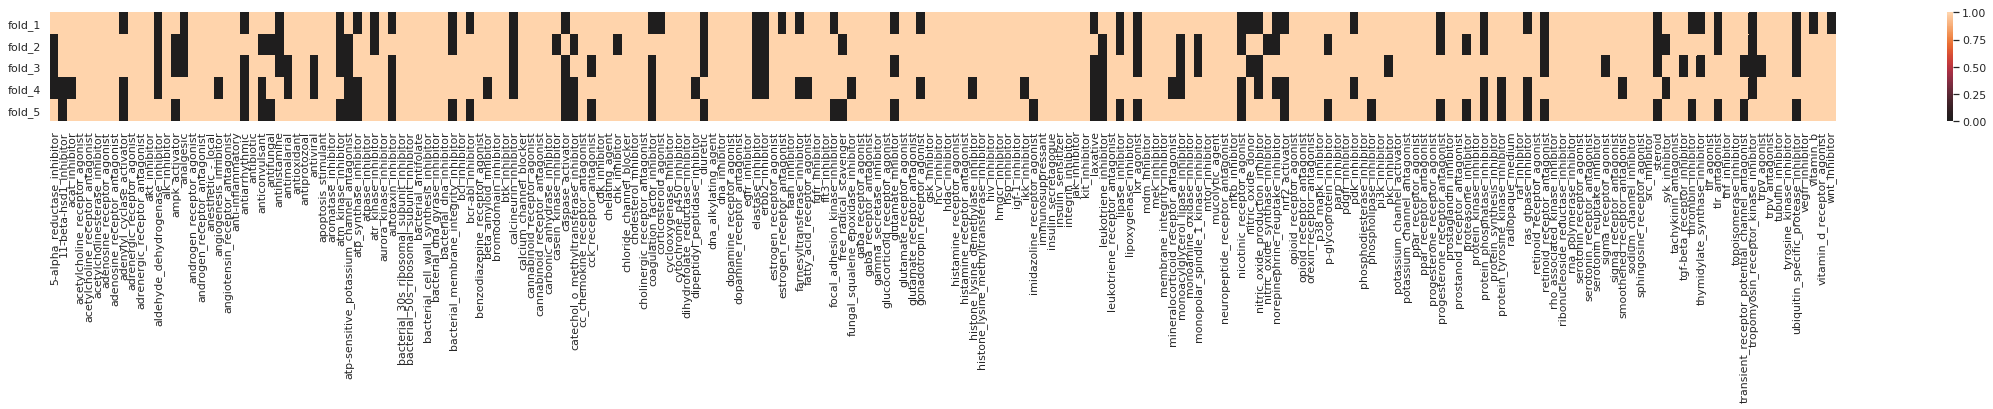

In [40]:
df_bin = df_count.copy()
df_bin[df_count==0] = 0
df_bin[df_count!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)

<br>

drug GroupKFoldだとどうなる？

In [41]:
target_trt = train_targets[mask_trt & ~mask_top8].copy()
folds = np.full(len(target_trt), -1)

splitter = GroupKFold(n_splits=n_splits)
for i, (trn_idx, val_idx) in enumerate(splitter.split(target_trt, groups=train_drug[mask_trt & ~mask_top8].drug_id)):
    folds[val_idx] =  i + 1
target_trt['fold'] = folds

In [42]:
list_df = []
for n in range(1, n_splits+1):
    mask_fold = target_trt['fold'] == n
    count = train_targets[mask_trt & ~mask_top8][mask_fold].sum(axis=0).values
    df_count = pd.DataFrame([count], columns=train_targets.columns)
    list_df.append(df_count)
df_count = pd.concat(list_df, axis=0)
df_count.index = [f'fold_{i}' for i in range(1, n_splits+1)]
df_count

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
fold_1,0,0,0,56,95,12,6,31,0,43,...,0,0,24,24,13,0,43,19,1,12
fold_2,0,0,6,23,37,0,6,23,0,101,...,0,6,6,19,24,0,36,6,12,6
fold_3,0,0,0,44,42,6,30,6,12,43,...,0,6,6,41,24,0,0,1,7,12
fold_4,17,12,12,24,54,31,0,19,0,41,...,0,13,12,12,12,0,38,0,12,0
fold_5,0,6,6,43,73,24,12,17,0,42,...,6,0,0,24,0,6,53,0,7,0


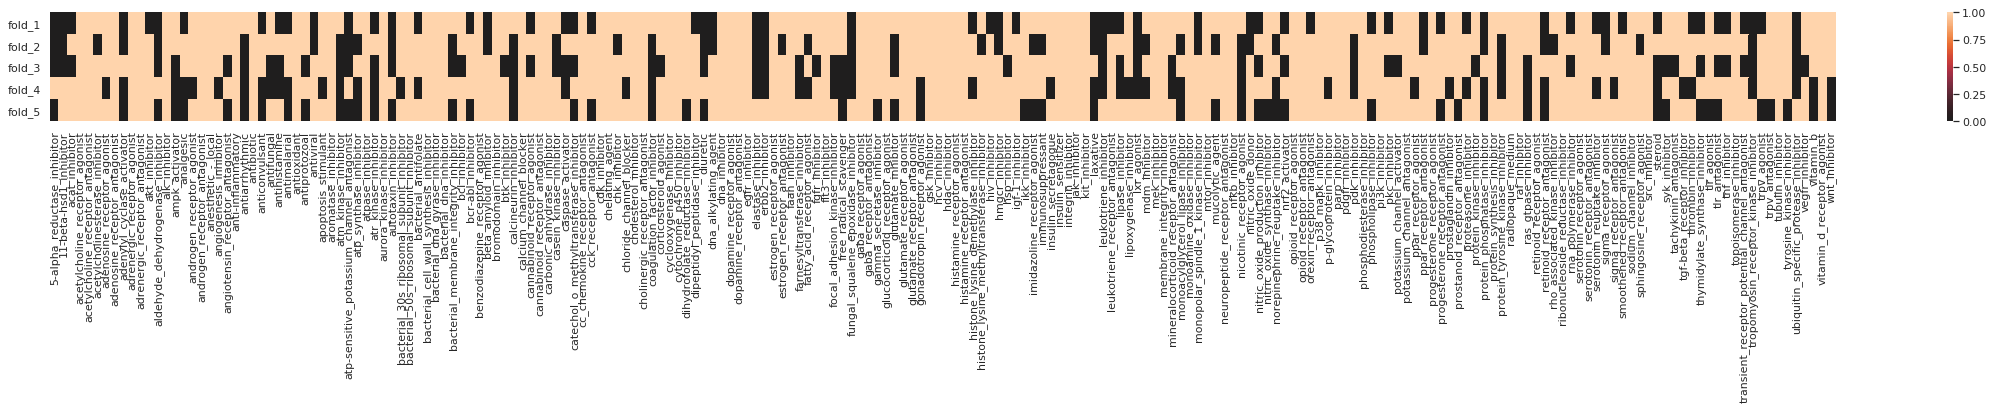

In [43]:
df_bin = df_count.copy()
df_bin[df_count==0] = 0
df_bin[df_count!=0] = 1

df = df_bin
plt.figure(figsize=(40, 2))
sns.heatmap(df,
            xticklabels=df.columns,
            yticklabels=df.index,
            center=0)

---> あれ、意外と悪いな...

# Create function

In [57]:
def get_not_drug_leak_folds(n_splits, train_features, train_drug, gruoup696):
    '''
    n_splits だけfoldを作成する。
    ただし、cp_type = ctl_vehicle と、top8にはfold=-1を割り振っている。
    
    696group のcsv: https://www.kaggle.com/fkubota/moa-nb004-696group
    
    ::example::
    train_features = pd.read_csv("train_features.csv")
    train_drug = pd.read_csv("train_drug.csv")
    group696 = pd.read_csv("MoA_nb004_696group/group.csv")
    df_fold = get_not_drug_leak_folds(5, train_features, train_drug, group696)
    '''
    TOP8_DRUG = ['87d714366', '9f80f3f77', '8b87a7a83', '5628cb3ee', 'd08af5d4b', '292ab2c28', 'd50f18348', 'd1b47f29d']
    mask_trt = (train_features['cp_type'] == 'trt_cp').values

    # mask_top8 を作成
    mask_top8 = []
    for drug_id in train_drug.drug_id.values:
        if drug_id in TOP8_DRUG:
            mask_top8.append(True)
        else:
            mask_top8.append(False)
    mask_top8 = np.array(mask_top8)
    
    # trt かつ top8 以外を抜き出す
    # group = 0 は要素数が多いので一番最後にやるようにする
    drug_groups = group696[mask_trt & ~mask_top8].group.values
    groups = np.sort(group696[mask_trt & ~mask_top8].group.unique())
    groups = groups[1:]
    groups = np.append(groups, 0)
    
    # 各グループにfoldを割り振る
    tile = []
    train_drug_trt = train_drug[mask_trt & ~mask_top8]
    train_drug_trt['fold'] = -1
    for i_grp, grp in enumerate(groups):
        if i_grp == 0:
            tile = np.arange(1, n_splits+1).astype(int)

        mask_grp = drug_groups == grp
        drug_rank = train_drug[mask_trt & ~mask_top8][mask_grp].drug_id.value_counts()

        n_repeat = np.ceil(len(drug_rank)/n_splits).astype(int)
        folds = np.tile(tile, n_repeat)[:len(drug_rank)]

        for i, drug_id in enumerate(drug_rank.index.sort_values()):
            mask = train_drug_trt.drug_id.values == drug_id
            train_drug_trt.fold[mask] = folds[i]
        tile = train_drug_trt.fold.value_counts()[::-1][:n_splits].index
        
    train_drug_fold = train_drug.copy()
    train_drug_fold['fold'] = -1
    train_drug_fold['fold'][mask_trt & ~mask_top8] = train_drug_trt.fold.values
    return train_drug_fold

In [48]:
group696.group.value_counts()[:30]

0      5530
13      718
25      363
53      337
47      328
54      310
5       304
38      295
30      293
80      292
26      288
52      283
10      263
34      255
3       251
157     240
28      229
105     221
20      218
56      216
16      205
35      186
40      184
168     180
110     129
76      128
116     115
33      103
160     102
82      102
Name: group, dtype: int64